# Imports

In [5]:
# Use the libraries for pandas, numpy and matplot
# These libraries are all executed in Python
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.signal import argrelextrema
import math
import shlex, subprocess
import os
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default') 
#pd.set_option('display.max_columns', 60) 

# Additional plotting capabilities:
# import plotly
# plotly.offline.init_notebook_mode()

# Functions for creating the distributions

In [33]:
#Creates an estimated histogram of the distribution. 
#It is estimated due to the challenge of integrating a sum of normal distributions.
#formulas = a lambda function (created via lambda x: formula) or an array of lambda functions
#Data_points = number of records in the data so that the plot will have the correct height
#x_range_min,x_range_max,steps defines the range of the plot
#name = used to save the plot as a figure, empty means no save
def graph_int(formulas, data_points, x_range_min, x_range_max, steps, name=""):
    if not isinstance(formulas, list):
        formulas = [formulas]
    for func in formulas:
        xs = np.arange(x_range_min, x_range_max, steps)
        ys = [(func(x+steps/2)+func(x-steps/2))/2*steps for x in xs]
        total = np.sum(ys)
        y = [data_points*y/total for y in ys]
        plt.plot(xs, y)
    ax = plt.gca()
    if name != "":
        plt.savefig(name)
    plt.show()
    return ax

#Create a normal distribution from mean and std, both of which are integers.
def generate_normal(mean, std):
    mean = str(mean)
    std = str(std)
    return '(1/math.sqrt(2*math.pi*'+std+'**2))*math.exp(-(x-'+mean+')**2/(2*'+std+'**2))'

#Creates an exponential distribution form the mean as an integer.
def generate_exp(mean):
    lambdaa = str(1/mean)
    return lambdaa+'*math.exp(-x*'+lambdaa+')'

#Takes data and fits a distribution to it and outputs the parameters
#file_in = the name of a file used is in the process
#file_out = the name of the output file
#shell_script = name of the script to run, which can also include the path, however .sh is appended automatically
#setup = whether to run a setup script which is normally generated by profido
#distr = the type of distribution possibilities are:
#auto         !Warning takes a long time!
#exponential
#normal
#lognormal
#johnson
#uniform
#triangular
#erlang
#gamme
def profido_params(data, file_in="input.txt", file_out="profido_output.txt", shell_script="normal", setup=False, distr="normal"):
    data.to_csv(file_in,index=False)
    if os.name == 'nt':
        if setup:
            os.system(shell_script+"_windows_setup.sh")
        os.system(shell_script+"_windows.sh "+ distr + " " + file_in + " " + file_out)
    else:
        if setup:
            os.system("./"+shell_script+"_linux_setup.sh")
        os.system("./"+shell_script+"_linux.sh "+ distr + " " + file_in + " " + file_out)
    with open(file_out) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    mean = content[4][6:][:-7]
    std = content[5][5:][:-6]
    return mean, std

#Takes data and fits a hyper_exponential distribution to it.
#Outputs the actual distribution which can be evaluated in python.
#em_type = the of fitting, for options look in main.c of em_fit
#phase_num = the number of exponential distributions
def em_fit(data, em_type='n',phase_num=1):
    data.to_csv("input.txt", index=False)
    try:
        os.remove("input.txt.bin")
    except OSError:
        pass
    if os.name == 'nt':
        args = ["em_fit.exe", "input.txt", em_type, str(phase_num)]
    else:
        args = ["./em_fit", "input.txt", em_type, str(phase_num)]
    with open('output.txt', 'w') as f:
        subprocess.call(args, stdout=f)
    with open('output.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    content = content[(phase_num+2):(phase_num*2+2)]
    for idx, line in enumerate(content):
        line = line.replace('exp', 'math.exp')
        content[idx] = line.replace('\\', '')
    content = ''.join(content)
    return content

#Takes data and fits a hyper_exponential distribution to it.
#Outputs the parameters as an array of type [lambda, p].
#em_type = the of fitting, for options look in main.c of em_fit
#phase_num = the number of exponential distributions
def em_fit_params(data, em_type, phase_num):
    data.to_csv("input.txt", index=False)
    try:
        os.remove("input.txt.bin")
    except OSError:
        pass
    if os.name == 'nt':
        args = ["em_fit.exe", "input.txt", em_type, str(phase_num)]
    else:
        args = ["./em_fit", "input.txt", em_type, str(phase_num)]
    with open('output.txt', 'w') as f:
        subprocess.call(args, stdout=f)
    with open('output.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    result = [None]*phase_num
    for i in range(phase_num):
        line = content[i+1].split(",")
        result[i] = [line[0].replace(' ', ''),line[1].replace(' ', '')[1:]]
    return result

#Combines a list of distributions into a single distribution
#distr_list = list of distribution
#ps = list of p values which indicate the strength of a distribution as a value in [0-1]
def generate_mix_distr(distr_list, ps):
    combined_distr = ''
    for idx, distr in enumerate(distr_list):
        combined_distr += str(ps[idx])+'*'+distr +'+'
    return combined_distr[:-1]

In [1]:
#Retrieves the values from a histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#until = maximal value of the data to be retrieved
#bin_size = width of each bin in the histogram
def get_values(data, column,until, bin_size):
    values, _ = np.histogram(data[column][data[column] < until], bins=range(round(until/bin_size)+1))
    return values

#Find best matching value for a peak
#array = options to choose from, if empty picks best from values
#values = the values of the histogram
#mini = minimal value of interval to pick from
#maxi = maximal value of interval to pick from
def find_best_match(array,values, mini, maxi):
    if len(array) > 0:
        idx = np.argmax([values[v] for v in array])
    else:
        return np.argmax(values[mini:maxi])+mini
    return array[idx]

#This is to detect minima that were missed earlier due to many values in a row being the exact same
#values = the values of the histogram
#maxima = list of maxima
#minima = list of minima
def find_zeros(values, maxima, minima):
    gaps = []
    for i in range(len(maxima)-1):
        if len(np.where(np.logical_and(minima>maxima[i], minima<maxima[i+1]))[0]) == 0:
            if maxima[i+1]-maxima[i] > 10:
                gaps = np.append(gaps, [np.argmin(values[maxima[i]:maxima[i+1]])+maxima[i]])        
    return gaps

#Improves the boundaries of the normal distributions.
#This is usefull since profido works better if there are not a lot of outliers
#boundaries = the original boundaries, which is an array of type [int,int]
#maxima = list of maxima
#values = the values of the histogram
#margin = the maximum percentage that the values are allowed to be off from the original
def refine_boundaries(boundaries, maxima, values, margin):
    for idx, bounds in enumerate(boundaries):
        m_value = values[maxima[idx]]
        l_value = values[bounds[0]]
        r_value = values[bounds[1]]
        l_margin = (m_value-l_value)/100*margin
        r_margin = (m_value-r_value)/100*margin
        current = m_value
        i = 1
        while (current > l_margin+l_value):
            current = values[maxima[idx]-i]
            i += 1
        new_l = maxima[idx]-i
        current = m_value
        i = 1
        while (current > r_margin+r_value):
            current = values[maxima[idx]+i]
            i += 1
        new_r = maxima[idx]+i
        boundaries[idx] = [new_l,new_r]
    return boundaries

#Find estimations of the boundaries of the normal distributions within the histogram.
#max_dur = maximum value of the data to be used
#bound_margin = used for refine_boundaries as margin
#column = the name of the column of the pandas dataset (can be an integer if required)
def get_boundaries(data, max_dur, bound_margin, column):
    values, binEdges = np.histogram(data[column][data[column] < max_dur], bins=range(max_dur+2))
    yhat = signal.savgol_filter(signal.savgol_filter(values, 3, 0),3,0)
    width = 3
    maxima = np.array(argrelextrema(yhat, np.greater, order=5)[0])
    minima = np.array(argrelextrema(yhat, np.less, order=5)[0])
    minima = np.sort(np.append(minima,find_zeros(values, maxima, minima)))
    if len(minima) == 0:
        return [[0,max_dur]],[find_best_match(maxima, yhat,0,max_dur)]
    if minima[0] > maxima[0]:
        minima = np.append([0],minima)
    if minima[-1] < maxima[-1]:
        minima = np.append(minima,[max_dur])
    new_maxima = [0]*(len(minima)-1)
    for i in range(len(minima)-1):
        j = i
        while j < len(maxima) and maxima[j] < minima[i+1]:
            j += 1
        new_maxima[i] = find_best_match(maxima[i:j], yhat, int(minima[i]), int(minima[i+1]))
        maxima = np.append(new_maxima[:i+1], maxima[j:])
    bounds = [None]*len(maxima)
    for i in range(len(maxima)):
        min_distance = min(maxima[i]-minima[i],minima[i+1]-maxima[i])
        bounds[i] = [int(maxima[i]-min_distance),int(maxima[i]+min_distance)]
    bounds = refine_boundaries(bounds, maxima, values, 5)
    return bounds, maxima

#Uses profido to fit a normal distribution to the data within the limits
#data_arg = all of the data
#limits = the lower and upper bound of the interval to fit in the form of [lower,upper]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the data to be used
#column = the name of the column of the pandas dataset (can be an integer if required)
def fit_normal(data_arg, limits, speedUp, until, column):
    data = data_arg[column][data_arg[column] > limits[0]][data_arg[column] <=limits[1]][::speedUp]
    p = len(data)/len(data_arg[column][data_arg[column] <=until][::speedUp])
    mean, std = profido_params(pd.DataFrame(data=np.sort(data)), 'input.txt', 'profido_output.txt', 'normal')
    return mean, std, str(p)

#Calculates the mean and variance for the given normal distributions
#ps = array of p values
#means = means of the distributions
#l = amount of distributions
#exp = expected value of the histogram based on the distribution
def get_mean_var(ps, means, l, exp):
    mean = np.sum([ps[x]*means[x] for x in range(l)])
    var = np.sum([exp[x]*(x-mean)**2 for x in range(0,len(exp))])/np.sum(exp)
    return mean, var

#Calculates a number which indicates how good the fit is.
#This is used over goodness of fit algorithms such as chi-sqaure due to the dataset being to large that it become oversensitive.
#values = the values of the histogram
#expected = expected value of the histogram based on the distribution
#data_size = size of the dataset
def get_average_error(values, expected, data_size):
    return np.sum([math.fabs(values[x]-expected[x])**2/data_size for x in range(len(values))])

#Calculates the normal distributions for all the boundaries given
#boundaries = the boundaries, which is an array of type [int,int]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the data to be used
#column = the name of the column of the pandas dataset (can be an integer if required)
def get_normals(data, boundaries, speedUp, until, column):
    l = (len(boundaries))
    ps = [None]*l
    normal_distrs = [None]*l
    means = [None]*l
    stds = [None]*l
    for idx, limits in enumerate(boundaries):
        means[idx], stds[idx],ps[idx] = (eval(r) for r in fit_normal(data,limits, speedUp, until, column))
        normal_distrs[idx] = generate_normal(means[idx],stds[idx])
    return l,ps,means,stds,normal_distrs

#Calcualtes the estimated expected values of a histogram for the given distribution
#size = size of the dataset
#func = the lambda function which represents the distribution. Can be created by using lambda x: eval(distribution) if distribution is a string
#bin_size = the width of bins of the histogram
#until = maximum value of the histogram
def get_exp(size,func,bin_size,until):
    return [round(size*(func(x+0.5*bin_size)+func(x-0.5*bin_size))/2)*bin_size for x in np.arange(0,until,bin_size)]

#Equalizes the p values so that the sum = 1
#ps = list of p values
def eq_ps(ps):
    t = np.sum(ps)
    for p in ps:
        p = p*1/t
    return ps

#Second step to refine the normal distributions. Works by changing the mean and std of each distribution.
#size = size of the dataset
#until = maximum value of the histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#normals = the list of normal distributions
#ps = list of p values
#means = list of means of the normal distributions
#maxima = list of maxima
#stds = list of stds of the normal distributions
#bin_size = the width of bins of the histogram
#values = the values of the histogram
#init_error = initial error as defined by get_average_error()
#iterations = how many times is iterated over all of the normal distributions, recommended is 3
def refine_normals_2(data, size, until, column, normals, ps,means, maxima,stds, bin_size, values, init_error, iterations=1):
    for _ in range(iterations):
        for i in range(len(maxima)):
            mean = means[i]
            std = stds[i]
            error = 0
            while (error < init_error):
                if error > 0:
                    init_error = error
                mean -= (means[i]-maxima[i])/10
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
            mean += (mean-maxima[i])/10
            means[i] = mean
            error = 0
            while (error < init_error):
                if error > 0:
                    init_error = error
                std -= stds[i]/100
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
            std += stds[i]/100
            error = 0
            if std == stds[i]:
                while (error < init_error):
                    if error > 0:
                        init_error = error
                    std += stds[i]/100
                    normals[i] = generate_normal(mean,std)
                    func = lambda x: eval(generate_mix_distr(normals, ps))
                    expected = get_exp(size, func, bin_size, until)
                    error = get_average_error(values,expected,size)
                std -= stds[i]/100
            stds[i] = std
            normals[i] = generate_normal(mean,std)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    return func, means,ps, normals, stds
    
#First step in improving the normal distributions. 
#Works by changing the boundaries and using profido to recalculate the normal distributions.
#size = size of the dataset
#boundaries = the boundaries, which is an array of type [int,int]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#normals = the list of normal distributions
#ps = list of p values
#means = list of means of the normal distributions
#stds = list of stds of the normal distributions
#bin_size = the width of bins of the histogram
#values = the values of the histogram
#init_error = initial error as defined by get_average_error()
#ref = how many times is iterated over all of the normal distributions, this can take a lot of time so keep the value under 10
def refine_normals(data, size, boundaries, speedUp, until, column, normals, ps,means,stds, bin_size, values, init_error,ref):
    for i in range(len(boundaries)):
        o_limit = boundaries[i]
        best_limit = o_limit
        best_normals = normals[i]
        best_p = ps[i]
        for _ in range(ref):
            best_limit[0] += 1
            mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
            normals[i] = generate_normal(mean,std)
            func = lambda x: eval(generate_mix_distr(normals, ps))
            expected = get_exp(size, func, bin_size, until)
            error = get_average_error(values,expected,size)
            if error < init_error:
                init_error = error
                #best_limit = limits
                best_normals = normals[i]
                best_p = ps[i]
                stds[i] = std
                means[i] = mean
            else: 
                best_limit[0] -= 1
                break;
        if (best_limit == o_limit):
            for _ in range(ref):
                best_limit[0] -= 1
                mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
                if error < init_error:
                    init_error = error
                    #best_limit = limits
                    best_normals = normals[i]
                    best_p = ps[i]
                    stds[i] = std
                    means[i] = mean
                else:
                    best_limit[0] += 1
                    break;
        o_limit = boundaries[i]
        for _ in range(ref):
            best_limit[1] += 1
            mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
            normals[i] = generate_normal(mean,std)
            func = lambda x: eval(generate_mix_distr(normals, ps))
            expected = get_exp(size, func, bin_size, until)
            error = get_average_error(values,expected,size)
            if error < init_error:
                init_error = error
                #best_limit = limits
                best_normals = normals[i]
                best_p = ps[i]
                stds[i] = std
                means[i] = mean
            else:
                best_limit[1] -= 1
                break;
        if (best_limit == o_limit):
            for _ in range(ref):
                best_limit[1] -= 1
                mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
                if error < init_error:
                    init_error = error
                    #best_limit = limits
                    best_normals = normals[i]
                    best_p = ps[i]
                    stds[i] = std
                    means[i] = mean
                else:
                    best_limit[1] += 1
                    break;
        boundaries[i] = best_limit
        normals[i] = best_normals
        ps[i] = best_p
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    return func, means,ps, normals, stds

#Used to find places without peaks but with data in the histogram
#values = the values of the histogram
#expected = expected value of the histogram based on the distribution
#size = size of the dataset
#until = maximum value of the histogram
def find_gaps(values, expected, size, until):
    result = []
    start = 0
    count = 0
    for i in range(len(values)):
        if expected[i] < size/until*0.01 and values[i] > expected[i]*10:
            if count == 0:
                start = i
            count += 1
        else:
            if count > 3:
                result.append([np.sum(values[start:start+count]/size),start+count/2,count/2])
            count = 0
    return result

#The acutal function used to find the distribution, which uses all the above functions
#data = the data of which the distribution should be calculated
#until = the maximum value for which there is relatively sufficient data, to prevent getting millions of normal distributions
#column = the column which contains the data to be fitted
#refine_factor = factor used in refine_normals, recommended to keep < 10
#refine_2_iterations = how many iterations refine_normals_2 will do for every distribution, recommended is 3
#bin_size = width of the bins in the histogram (this is not tested very well so recommended to keep at 1)
#bound_margin = is a margin used for refining the bounds
#fast = whether the speedUp factor should be used
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#plot_name = saves the plot as a file, if empty does not save the plot
def find_distr(data, until, column='duration_processing', refine_factor=3, refine_2_iterations=1, bin_size=1, bound_margin=3,\
               fast=True, speedUp=1000, plot_name=""):
    if not fast:
        speedUp = 1
    boundaries, maxima = get_boundaries(data,until,bound_margin, column)
    size = len(data[column][data[column] < until])
    l,ps,means,stds,normals = get_normals(data, boundaries, speedUp, until, column)
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    values = get_values(data,column,until, bin_size)
    expected = get_exp(size, func, bin_size, until)
    gaps = find_gaps(values,expected,size,until)
    for gap in gaps:
        ps.append(gap[0])
        means.append(gap[1])
        stds.append(gap[2])
        normals.append(generate_normal(gap[1],gap[2]))
        maxima = np.append(maxima,[gap[1]])
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    values = get_values(data,column,until, bin_size)
    expected = get_exp(size, func, bin_size, until)
    average_error = get_average_error(values,expected,size)
    
    print("before:")
    print(np.corrcoef(values, expected))
    mean, var = get_mean_var(ps,means,l, expected) 
    print(np.mean(data[column][data[column] < until]),mean)
    print(np.var(data[column][data[column] < until]),var)
    print(average_error)
    
    func, means, ps, normals, stds = refine_normals(data, size, boundaries, speedUp, until, column, normals, ps, means, stds, bin_size, values, average_error,refine_factor)
    func, means, ps, normals, stds = refine_normals_2(data, size, until, column, normals, ps,means, maxima,stds, bin_size, values, average_error, refine_2_iterations)
    ps = eq_ps(ps)
    expected = get_exp(size, func, bin_size, until)
    average_error = get_average_error(values,expected,size)
    
    print("after:")
    print(np.corrcoef(values, expected))
    mean, var = get_mean_var(ps,means,l, expected) 
    print(np.mean(data[column][data[column] < until]),mean)
    print(np.var(data[column][data[column] < until]),var)
    print(average_error)
    plt.figure(figsize=(20,5))
    plt.hist(data[column][data[column] < until], bins=range(round(until/bin_size)+1))
    ax =graph_int(func,size,0,until,bin_size)
    for i in range(len(normals)):
        print(ps[i],stds[i],means[i])
    return generate_mix_distr(normals,ps)

# Extend dataset with service_time

# Rest

In [30]:
#Imports the data from the extended dataset which includes service -,inter_arrival - and completion times
#Format is slightly different then the non extended dataset due to exporting, therefor this is the way to import
location = 'extended_data_1.csv.gz'
data_IA = pd.read_csv(location, 
        compression='gzip', index_col=0)

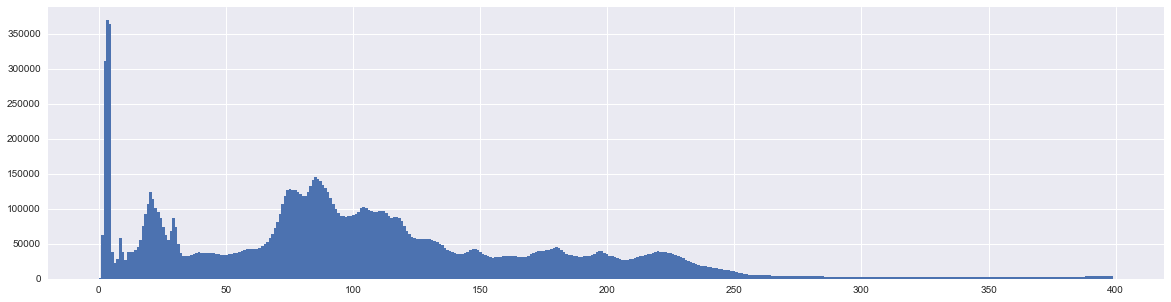

In [10]:
data_IA['duration_processing'][data_IA['duration_processing']< 400].hist(bins=400, figsize=(20,5))

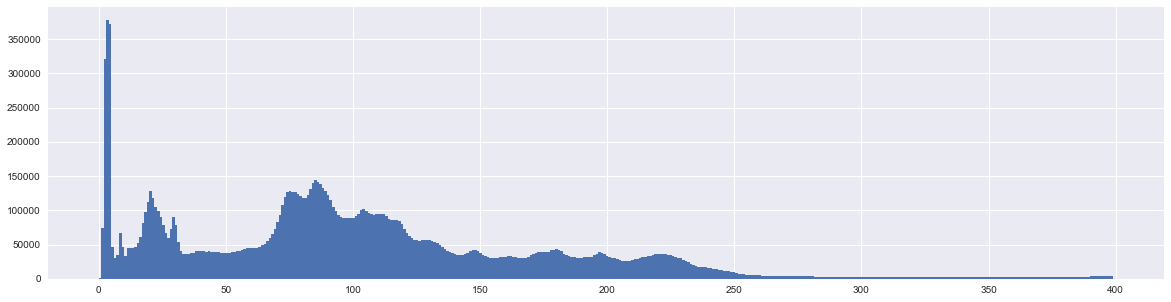

In [27]:
data_IA['service_time'][data_IA['service_time']< 400].hist(bins=400, figsize=(20,5))

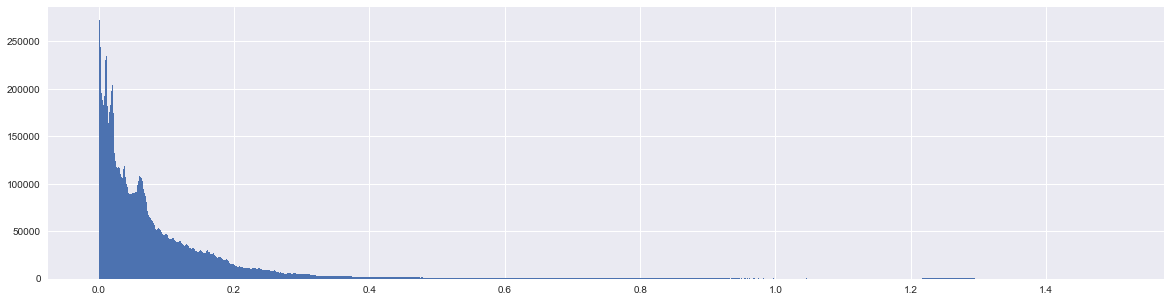

In [11]:
data_IA['inter_arrival'][data_IA['inter_arrival'] < 1.5].hist(bins=1500,figsize=(20,5))

10.043316825468246
10.043316825468246*math.exp(-x*10.043316825468246)


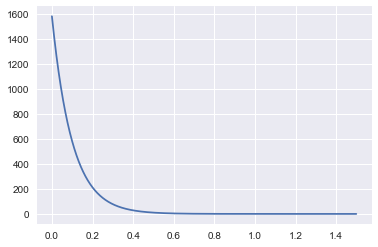

In [15]:
max_x = 1.5
step = 0.001
data = data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x][::100]
mean, std = profido_params(pd.DataFrame(data=np.sort(data)), 'input.txt', 'profido_output.txt', 'exponential')
lambdaa = str(1/eval(mean))
exp_distr = lambdaa+'*math.exp(-x*'+lambdaa+')'
print(lambdaa)
print(exp_distr)
graph_int(lambda x:eval(exp_distr),len(data),0,max_x,step)

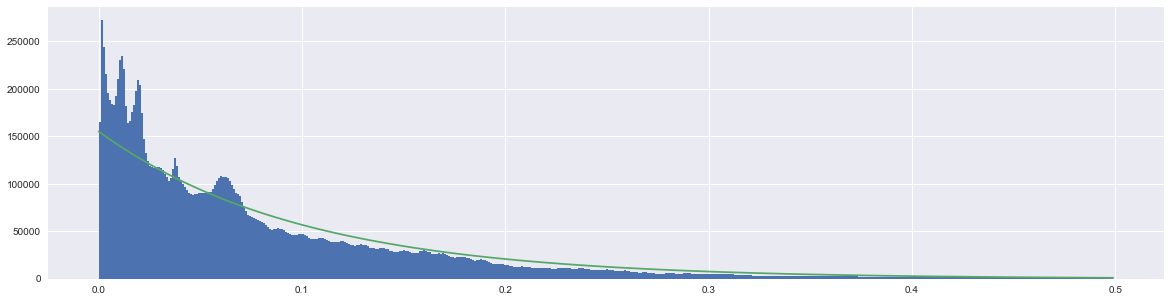

In [16]:
plt.figure(figsize=(20,5))
steps = 0.001
max_x = .5
values, binEdges = np.histogram(data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x], bins=500)
data = data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x]
y, x, _ = plt.hist(data,bins=500)
graph_int(lambda x: eval(exp_distr), np.sum(values),0,.5,0.001)

1.406600e+001 9.109022e-001
2.183792e+000 8.291375e-002
4.699582e-001 6.107866e-003
4.699549e-001 7.537564e-005
4.699547e-001 7.711090e-007
9.109022e-001*(14.066*math.exp(-x*14.066))+8.291375e-002*(2.183792*math.exp(-x*2.183792))+6.107866e-003*(0.46995819999999994*math.exp(-x*0.46995819999999994))+7.537564e-005*(0.4699549*math.exp(-x*0.4699549))+7.711090e-007*(0.4699547*math.exp(-x*0.4699547))


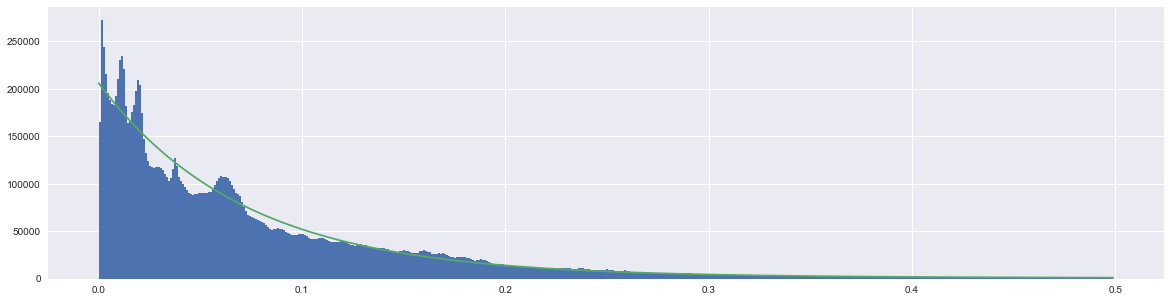

In [17]:
plt.figure(figsize=(20,5))
data = data_IA['inter_arrival'][::100]
fit = em_fit_params(data,'n',5)
for exp in fit:
    print(exp[0],exp[1])
he_distr = '+'.join([exp[1]+'*('+generate_exp(1/eval(exp[0]))+')' for exp in fit])
print(he_distr)
data = data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x]
y, x, _ = plt.hist(data,bins=500)
graph_int(lambda x: eval(he_distr), np.sum(values),0,.5,0.001)

before:
[[ 1.          0.89500786]
 [ 0.89500786  1.        ]]
99.20886694017857 61.9232483513
4456.07987922054 5794.18667793
13160.4168679
after:
[[ 1.          0.98086048]
 [ 0.98086048  1.        ]]
99.20886694017857 88.1746969468
4456.07987922054 4179.69166662
1728.64468535


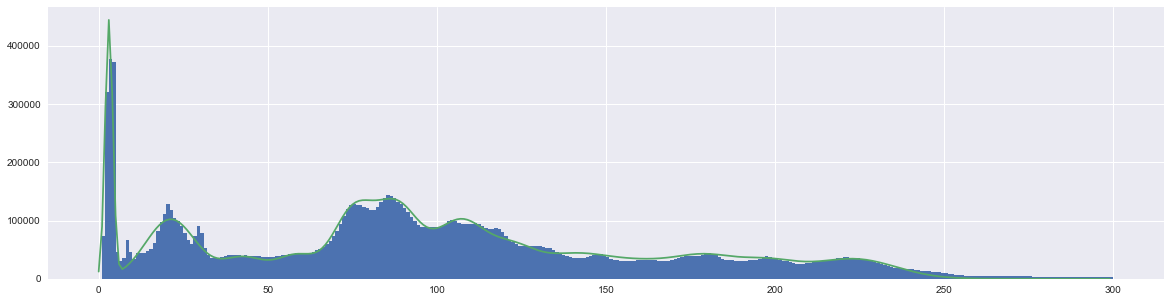

0.083526999316473 1.0056275999999995 3.04090218665
0.12652084757347914 7.398813312000003 21.3007470585
0.03766233766233766 6.2767228649999876 42.7248027051
0.11237183868762816 5.976438468000006 75.2229850672
0.12836637047163363 6.39927398447999 88.2098328606
0.12638414217361585 7.666745299200008 107.066156695
0.083526999316473 11.88148244400001 140.523473386
0.036568694463431306 9.956866381999998 163.081138527
0.04859876965140123 8.690984676 179.566800986
0.041353383458646614 8.865527468000003 197.433199014
0.07040328092959672 12.3594 223.236536871
0.038578508419 5.900699999999996 58.5
0.0406962315658 6.355799999999999 122.5


In [29]:
distribution = find_distr(data_IA,300,refine_factor=20, refine_2_iterations=10, column='service_time')

In [20]:
distribution

'0.08033260032985157*(1/math.sqrt(2*math.pi*0.9704184**2))*math.exp(-(x-3.03366713005)**2/(2*0.9704184**2))+0.10940076965365586*(1/math.sqrt(2*math.pi*6.673898907000007**2))*math.exp(-(x-20.8985702106)**2/(2*6.673898907000007**2))+0.05628092358438703*(1/math.sqrt(2*math.pi*9.202323735000006**2))*math.exp(-(x-42.3030941818)**2/(2*9.202323735000006**2))+0.11256184716877406*(1/math.sqrt(2*math.pi*5.9851250534400045**2))*math.exp(-(x-75.0961605542)**2/(2*5.9851250534400045**2))+0.14444749862561848*(1/math.sqrt(2*math.pi*6.917939149280006**2))*math.exp(-(x-88.3156455634)**2/(2*6.917939149280006**2))+0.12946673996701485*(1/math.sqrt(2*math.pi*7.530785745600008**2))*math.exp(-(x-107.63923347)**2/(2*7.530785745600008**2))+0.08541781198460692*(1/math.sqrt(2*math.pi*11.386257756**2))*math.exp(-(x-140.299186631)**2/(2*11.386257756**2))+0.03717702034084662*(1/math.sqrt(2*math.pi*9.54053515999999**2))*math.exp(-(x-162.698785883)**2/(2*9.54053515999999**2))+0.050302363936228695*(1/math.sqrt(2*math.p